In [1]:
# read csv file and print out the data
import csv
import sys
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datapath = '../data/2011-2012 Solar home electricity data v2.csv'
# skip the first line in csv and read the next line as column
# then read the rest of the file and store as dataframe
df = pl.read_csv(datapath, skip_rows=1)
print(df)
print(df.columns)

shape: (270_304, 54)
┌──────────┬───────────┬──────────┬──────────────────────┬───┬───────┬───────┬───────┬─────────────┐
│ Customer ┆ Generator ┆ Postcode ┆ Consumption Category ┆ … ┆ 23:00 ┆ 23:30 ┆ 0:00  ┆ Row Quality │
│ ---      ┆ Capacity  ┆ ---      ┆ ---                  ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---         │
│ i64      ┆ ---       ┆ i64      ┆ str                  ┆   ┆ f64   ┆ f64   ┆ f64   ┆ str         │
│          ┆ f64       ┆          ┆                      ┆   ┆       ┆       ┆       ┆             │
╞══════════╪═══════════╪══════════╪══════════════════════╪═══╪═══════╪═══════╪═══════╪═════════════╡
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 1.063 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GC                   ┆ … ┆ 0.118 ┆ 0.219 ┆ 0.162 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GG                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆

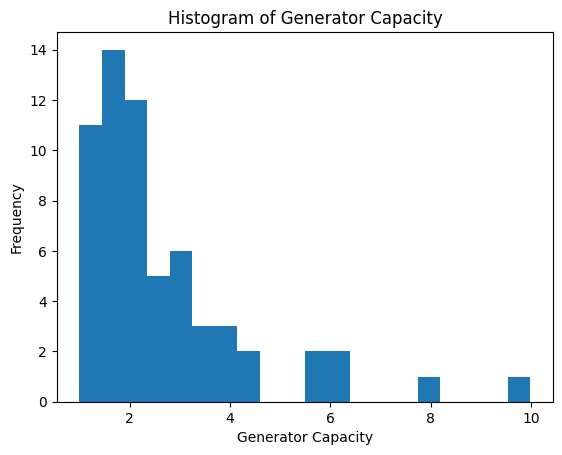

In [3]:
# show me different values in 'Generator Capacity'
GenCap = df['Generator Capacity'].unique()

# plot histogram of 'Generator Capacity'
plt.hist(GenCap, bins=20)
plt.xlabel('Generator Capacity')
plt.ylabel('Frequency')
plt.title('Histogram of Generator Capacity')
plt.show()


In [3]:
from helper import transform_polars_df

# get all the unique customers as their own dataframes
customers = df['Customer'].unique()
# pick 80% of the random customers as training data
training_customers = np.random.choice(customers, int(0.8*len(customers)), replace=False)
# the rest of the customers are testing data
testing_customers = np.setdiff1d(customers, training_customers)

In [4]:
# loop through each customer and use transform_polars_df to get the dataframe and store it in a list call dataset
training_dataset = []
for customer in training_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except:
        print(f"Error with customer {customer}")
        break
    training_dataset.append(newcustomerdf)

testing_dataset = []
for customer in testing_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except:
        print(f"Error with customer {customer}")
        break
    testing_dataset.append(newcustomerdf)


In [5]:
customerdf = training_dataset[0]
# check for index of df
print(customerdf.columns)
print(customerdf.head())


['Time', 'SolarGen', 'HouseLoad', 'FutureSolar', 'FutureLoad', 'ImportEnergyPrice', 'ExportEnergyPrice']
shape: (5, 7)
┌────────────────┬──────────┬───────────┬─────────────┬────────────┬───────────────┬───────────────┐
│ Time           ┆ SolarGen ┆ HouseLoad ┆ FutureSolar ┆ FutureLoad ┆ ImportEnergyP ┆ ExportEnergyP │
│ ---            ┆ ---      ┆ ---       ┆ ---         ┆ ---        ┆ rice          ┆ rice          │
│ i64            ┆ f64      ┆ f64       ┆ f64         ┆ f64        ┆ ---           ┆ ---           │
│                ┆          ┆           ┆             ┆            ┆ f64           ┆ f64           │
╞════════════════╪══════════╪═══════════╪═════════════╪════════════╪═══════════════╪═══════════════╡
│ 13094784000000 ┆ 0.0      ┆ 0.144     ┆ 0.0         ┆ 0.131      ┆ 0.1           ┆ 0.08          │
│ 00             ┆          ┆           ┆             ┆            ┆               ┆               │
│ 13094802000000 ┆ 0.0      ┆ 0.131     ┆ 0.0         ┆ 0.144      ┆ 0.1 

In [5]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from EnergySimEnv import SolarBatteryEnv


# Helper: create an environment instance from a dataset.
def make_env(dataset):
    def _init():
        env = SolarBatteryEnv(dataset)
        return env
    return _init

# Create a list of environment creation functions to build a vectorized environment.
env_fns = [make_env(ds) for ds in training_dataset]
vec_env = DummyVecEnv(env_fns)


# Train first agent with PPO
ppo_model = PPO("MlpPolicy", vec_env, verbose=1, device='cpu')
ppo_model.learn(total_timesteps=10000)
ppo_model.save("ppo_agent")

# Train second agent with A2C (different policy/algorithm)
a2c_model = A2C("MlpPolicy", vec_env, verbose=1)
a2c_model.learn(total_timesteps=10000)
a2c_model.save("a2c_agent")

print("Training complete. Both PPO and A2C agents are saved.")


/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device


/code/src/batterydeg.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / degradation_factor


-------------------------------
| time/              |        |
|    fps             | 26084  |
|    iterations      | 1      |
|    time_elapsed    | 18     |
|    total_timesteps | 491520 |
-------------------------------


/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/utils.py:66: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else float(1 - np.var(y_true - y_pred) / var_y)


Using cuda device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Training complete. Both PPO and A2C agents are saved.
